In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# il primo è una prova

In [123]:
class Encoder(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, latent_dim, num_layers=1):
        super(Encoder, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fcmu = nn.Linear(hidden_dim, latent_dim)
        self.fclogvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        embedded_input = self.embedding(x)
        _, hidden = self.gru(embedded_input)
        mu = self.fcmu(hidden)
        logvar = self.fclogvar(hidden)
        return mu, logvar, hidden, embedded_input
    
    def reparametrization(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, latent_dim, num_layers=1):
        super(Decoder, self).__init__()
        #self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x, hidden):
        #x = self.embedding(x)
        output, _ = self.gru(x, hidden)
        output = self.fc(output)
        return output, _
    
class VAE(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, latent_dim, sos_token, num_layers=1):
        super(VAE, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]
        self.sos_token = torch.FloatTensor(sos_token)
        #self.sos_token = self.sos_token.type(torch.FloatTensor)
        
        self.encoder = Encoder(embedding_matrix, hidden_dim, latent_dim)
        self.decoder = Decoder(self.embedding_dim, hidden_dim, latent_dim)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        mu, logvar, hidden, embedded_input = self.encoder(x)
        # Use <SOS> token for the initial input to the decoder
        #sos_token = torch.FloatTensor([[1]]).repeat(x.size(0), x.size(1), self.embedding_dim).to(x.device)
        sos_token = self.sos_token.repeat(x.size(0), x.size(1),1)
        outputs, _ = self.decoder(sos_token, hidden)
        return mu, logvar, outputs, embedded_input

In [104]:
sos_token = torch.tensor([[1,2]], dtype=torch.long).repeat(32, 10,1)

In [3]:
class GRUVAE(nn.Module):
    def __init__(self, embedding_matrix, embedd_dim, hidden_dim, latent_dim, num_layers):
        super(GRUVAE, self).__init__()

        self.embedder = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(embedd_dim)
        self.encoder = nn.GRU(embedd_dim, hidden_dim, num_layers, batch_first=True) # (N,B,H) N batches, B sequence length, H input dim
        self.fcmu = nn.Linear(hidden_dim, latent_dim)
        self.fcvar = nn.Linear(hidden_dim, latent_dim)

        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.GRU(embedd_dim, hidden_dim,num_layers,batch_first=True)
        self.fc_out = nn.Linear(hidden_dim,embedd_dim)

    def forward(self, x):
        embedded_input = self.embedder(x)
        out = self.layer_norm(embedded_input)
        _, hn = self.encoder(out)
        mu = self.fcmu(hn)
        log_var = self.fcvar(hn)
        z = self.reparametrization(mu,log_var)

        decoder_input = self.fc(z)
        dec_output,_ = self.decoder(embedded_input, decoder_input)
        output = self.fc_out(dec_output)

        return output, embedded_input, mu, log_var


    def reparametrization(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def sample(self, x, z):
        embedded_input = self.embedder(x)
        out = self.layer_norm(embedded_input)
        _, hn = self.encoder(out)

        decoder_input = self.fc(z)
        dec_output,_ = self.decoder(embedded_input, decoder_input)
        output = self.fc_out(dec_output)

        return output
    
        


In [25]:
class GRUVAE(nn.Module):
    def __init__(self, embedding_matrix, embedd_dim, hidden_dim, latent_dim, num_layers):
        super(GRUVAE, self).__init__()

        self.embedder = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(embedd_dim)
        self.encoder = nn.GRU(embedd_dim, hidden_dim, num_layers, batch_first=True) # (N,B,H) N batches, B sequence length, H input dim
        self.fcmu = nn.Linear(hidden_dim, latent_dim)
        self.fcvar = nn.Linear(hidden_dim, latent_dim)

        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.GRU(latent_dim, hidden_dim,num_layers,batch_first=True)
        self.fc_out = nn.Linear(hidden_dim,embedd_dim)

    def forward(self, x):
        embedded_input = self.embedder(x)
        out = self.layer_norm(embedded_input)
        _, hn = self.encoder(out)
        mu = self.fcmu(hn)
        log_var = self.fcvar(hn)
        z = self.reparametrization(mu,log_var)


        dec_output,_ = self.decoder(z)
        output = self.fc_out(dec_output)

        return output, embedded_input, mu, log_var


    def reparametrization(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def sample(self, x, z):
        embedded_input = self.embedder(x)
        out = self.layer_norm(embedded_input)
        _, hn = self.encoder(out)

        decoder_input = self.fc(z)
        dec_output,_ = self.decoder(embedded_input, decoder_input)
        output = self.fc_out(dec_output)

        return output
    
        


# Train function

In [4]:
def vae_loss(recon_x, x, mu, log_var, l_s = 0.03, loss_fn = nn.MSELoss(), cos_loss = nn.CosineSimilarity(dim=2), wrong = nn.L1Loss()):
    BCE = loss_fn(recon_x, x)
    #BCE = 1 - cos_loss(recon_x,x).mean()
    #BCE = wrong(recon_x,x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + l_s*KLD

In [62]:
def training_VAE(vae, train_loader, val_loader, num_epochs, lr = 1e-3):
    params = list(vae.parameters())

    optimizer = torch.optim.Adam(params, lr = lr)

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0

        for data,_,_ in train_loader:
            data = data.to(device)

            optimizer.zero_grad()

            mu, log_var, reconstructed_data, embedded_input = vae(data)

            loss = vae_loss(reconstructed_data, embedded_input, mu, log_var)
            loss.backward()
            train_loss += loss.item()

            optimizer.step()

        average_loss = train_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch+1} Average loss: {average_loss:.4f}')
        train_losses.append(average_loss)

        with torch.no_grad():
            for data,_,_ in val_loader:
                data = data.to(device)


                mu, log_var, reconstructed_data, embedded_input = vae(data)

                loss = vae_loss(reconstructed_data, embedded_input, mu, log_var)
                val_loss += loss.item()

        
        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)

    plt.plot(np.linspace(1,num_epochs,len(train_losses)), train_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    return train_losses

In [18]:
def BoW(tensor):
    bow = torch.zeros(size = (tensor.shape[0],tensor.shape[1]))
    #BoW = [(data1[i] == num).sum().item()/data1.shape[1]  for i in range(data1.shape[0]) for num in data1[i] if BoW[i][torch.where(data1[i] == num)[0][0].item()]==0]

    for i in range(tensor.shape[0]):
        for num in tensor[i]:
            index = torch.where(tensor[i] == num)[0][0].item()
            bow[i][index] = (tensor[i] == num).sum().item()/tensor.shape[1]

    return torch.FloatTensor(bow)

In [19]:
def divide_text(text, sequence_length):
    words = text.split()
    #words = text
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/4))]  # range (0,len(words),8)
    #grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),2)]
    #grouped_words = [words[i] for i in range(0,len(words),19)]
    #grouped_words_2d = [sentence.split() for sentence in grouped_words]
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]
    return output_text

In [81]:
def custom_dataset(file1 : str,file2 : str, sequence_length, embedding_dim, batch_size, training_fraction):

    with open(file1, 'r', encoding='utf-8') as f:
        text1 = f.read()


    with open(file2, 'r', encoding='utf-8') as f:
        text2 = f.read()

    text1 = '<SOS> ' + text1
    text = text1 + ' ' + text2
    divided_text = divide_text(text, sequence_length)

    #word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = int(sequence_length/2), min_count=1, workers=4)
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = 1, min_count=1, workers=4, epochs=50)
    #word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=20)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    # Convert to PyTorch tensor
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)



    text1_divided = divide_text(text1, sequence_length)
    data1 = torch.LongTensor([[word2idx[char] for char in text1_divided[i]] for i in range(len(text1_divided))])


    text2_divided = divide_text(text2, sequence_length)
    data2 = torch.LongTensor([[word2idx[char] for char in text2_divided[i]] for i in range(len(text2_divided))])


    data1_train = data1[:int(training_fraction * data1.shape[0])]
    data1_val = data1[int(training_fraction * data1.shape[0]):]

    data2_train = data2[:int(training_fraction * data2.shape[0])]
    data2_val = data2[int(training_fraction * data2.shape[0]):]


    label0_train = torch.zeros(data1_train.shape[0])
    label0_val = torch.zeros(data1_val.shape[0])

    label1_train = torch.ones(data2_train.shape[0])
    label1_val = torch.ones(data2_val.shape[0])


    labels_train = torch.cat((label0_train, label1_train), dim = 0)
    labels_val = torch.cat((label0_val, label1_val), dim = 0)

    data_train = torch.cat((data1_train, data2_train), dim = 0)
    data_val = torch.cat((data1_val, data2_val), dim = 0)

    data_train = torch.LongTensor(data_train)
    labels_train = labels_train.type(torch.LongTensor)
    bow_train = BoW(data_train)

    dataset_train = TensorDataset(data_train, bow_train, labels_train)

    # Create a DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
    #dataloader_train = DataLoader(dataset_train, batch_size = batch_size)


    data_val = torch.LongTensor(data_val)
    labels_val = labels_val.type(torch.LongTensor)
    bow_val = BoW(data_val)

    dataset_val = TensorDataset(data_val, bow_val, labels_val)

    # Create a DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    #dataloader_val = DataLoader(dataset_val, batch_size = batch_size)

    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, vocab_size

In [82]:
sequence_length = 15
embedding_dim = 300
hidden_dim = 256
latent_dim = 136
batch_size = 32

In [83]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, vocab_size = custom_dataset('divina_commedia.txt', 
                                                                                     'uno_nessuno_e_i_malavoglia.txt', 
                                                                                     sequence_length, 
                                                                                     embedding_dim,
                                                                                     batch_size = batch_size, 
                                                                                     training_fraction = 0.9)
print('len train loader: ', len(train_loader))

len train loader:  1905


In [84]:
vocab_size

20249

In [22]:
vae = GRUVAE(embedding_matrix, embedding_dim, hidden_dim, latent_dim,1)

In [23]:
vae_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Total parameters: ', vae_params)

Total parameters:  913812


In [151]:
sos_token = word2vec.wv['<SOS>']
word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
word2idx['<SOS>']
#sos_token = torch.FloatTensor(sos_token)
#sos_token.shape
#idx2word[20249]

KeyError: 20249

In [134]:
vae = VAE(embedding_matrix, hidden_dim, latent_dim, sos_token)

In [135]:
vae_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Total parameters: ', vae_params)

Total parameters:  1039044


  0%|          | 0/10 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 0.0114


 10%|█         | 1/10 [00:58<08:50, 58.98s/it]

====> Epoch: 2 Average loss: 0.0102


 20%|██        | 2/10 [01:58<07:55, 59.41s/it]

====> Epoch: 3 Average loss: 0.0093


 30%|███       | 3/10 [02:58<06:57, 59.68s/it]

====> Epoch: 4 Average loss: 0.0088


 40%|████      | 4/10 [03:58<05:57, 59.66s/it]

====> Epoch: 5 Average loss: 0.0085


 50%|█████     | 5/10 [04:58<04:58, 59.79s/it]

====> Epoch: 6 Average loss: 0.0082


 60%|██████    | 6/10 [05:58<03:59, 59.88s/it]

====> Epoch: 7 Average loss: 0.0080


 70%|███████   | 7/10 [06:59<03:00, 60.18s/it]

====> Epoch: 8 Average loss: 0.0078


 80%|████████  | 8/10 [07:59<02:00, 60.12s/it]

====> Epoch: 9 Average loss: 0.0076


 90%|█████████ | 9/10 [09:01<01:00, 60.73s/it]

====> Epoch: 10 Average loss: 0.0075


100%|██████████| 10/10 [10:06<00:00, 60.64s/it]


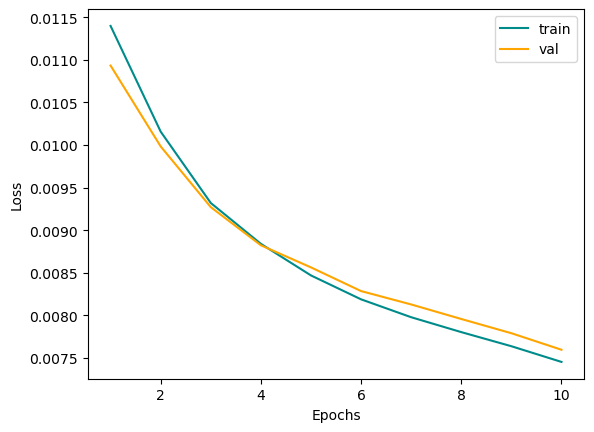

In [136]:
losses = training_VAE(vae, train_loader, val_loader,10)

In [148]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    mu, log_var, reconstructed, embedded_input = vae(prova)

reconstructed = reconstructed.view(reconstructed.shape[1], reconstructed.shape[2])
ricostruzione = []
for i in range(reconstructed.shape[0]):
    ricostruzione.append((word2vec.wv.most_similar(np.array(reconstructed[i]),topn=1)[0][0]))

if labels.item() == 0.0:
    stile = 'Dante'
else: 
    stile = 'Italiano'

print('Stile: ', stile)
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))

Stile:  Dante
Input sequence: 
 questa credenza ci convene silogizzar sanz avere altra vista però intenza d argomento tene allora

Reconstructed sequence: 
 questa angosciati iv rivene battendo quod trionfante trionfante trionfante sostituito abbandonarvi d acquasparta battendo stenebraron


In [35]:
reconstructed.shape

torch.Size([1, 15, 300])

In [16]:
mu.shape

torch.Size([1, 136])

In [19]:
z = torch.randn(1,latent_dim).to(device)

with torch.no_grad():
    out = VAE.sample(prova,z)

ricostruzione = []
for i in range(out.shape[0]):
    ricostruzione.append((word2vec.wv.most_similar(np.array(out[i]),topn=1)[0][0]))

In [20]:
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))


Reconstructed sequence: 
 laggiù all ospedale la nunziata si metteva a piangere anch essa e diceva di no


# prove

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, max_sequence_len, latent_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.bilstm1 = nn.LSTM(embed_dim, 256, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.15)
        self.bilstm2 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)  # 512 because 256 * 2 for bidirectional
        self.z_mean = nn.Linear(256, latent_dim)  # 128 * 2 for bidirectional
        self.z_log_var = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm1(x)
        x = self.dropout(x)
        _, (hn, _) = self.bilstm2(x)
        hn = torch.cat((hn[-2], hn[-1]), dim=1)  # Concatenate the final states of both directions
        z_mean = self.z_mean(hn)
        z_log_var = self.z_log_var(hn)
        return z_mean, z_log_var
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, sequence_length):
        super(Decoder, self).__init__()
        self.dense = nn.Linear(latent_dim, 128)
        self.repeat = nn.Linear(128, sequence_length * 64)  # Dense layer followed by reshape
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.output_dense = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = self.dense(x)
        x = torch.relu(x)
        x = self.repeat(x)
        x = x.view(-1, sequence_length, 64)  # Reshape to (batch_size, max_sequence_len, 64)
        x, _ = self.lstm(x)
        x = self.output_dense(x)
        return x

In [28]:
def reparameterize(z_mean, z_log_var):
    std = torch.exp(0.5 * z_log_var)
    epsilon = torch.randn_like(std)
    return z_mean + std * epsilon

In [29]:
class VAE(nn.Module):
    def __init__(self, input_dim, embed_dim, max_sequence_len, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, embed_dim, max_sequence_len, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, max_sequence_len)

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = reparameterize(z_mean, z_log_var)
        decoded = self.decoder(z)
        return z_mean, z_log_var, decoded

In [30]:
input_dim = 10000  # Vocabulary size or number of unique tokens
embed_dim = 128    # Dimension of embeddings
max_sequence_len = 30  # Length of sequences
latent_dim = 50    # Size of the latent vector
output_dim = 10000  # Output dimension (same as input_dim for token probabilities)

# Create the model
vae = VAE(input_dim, embed_dim, max_sequence_len, latent_dim, output_dim)

# Example input: batch_size=32, sequence length=30
example_input = torch.randint(0, input_dim, (32, max_sequence_len))

# Forward pass
z_mean, z_log_var, decoded = vae(example_input)

print("z_mean shape:", z_mean.shape)  # Should be (32, latent_dim)
print("decoded shape:", decoded.shape)  # Should be (32, max_sequence_len, output_dim)

z_mean shape: torch.Size([32, 50])
decoded shape: torch.Size([64, 15, 10000])


In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, max_sequence_len, latent_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.bilstm1 = nn.LSTM(embed_dim, 256, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.15)
        self.bilstm2 = nn.LSTM(512, 128, bidirectional=True, batch_first=True)  # 512 because 256 * 2 for bidirectional
        self.z_mean = nn.Linear(256, latent_dim)  # 128 * 2 for bidirectional
        self.z_log_var = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm1(x)
        x = self.dropout(x)
        _, (hn, _) = self.bilstm2(x)
        h_n = torch.cat((hn[-2], hn[-1]), dim=1)  # Concatenate the final states of both directions
        z_mean = self.z_mean(h_n)
        z_log_var = self.z_log_var(h_n)
        return z_mean, z_log_var, hn

def reparameterize(z_mean, z_log_var):
    std = torch.exp(0.5 * z_log_var)
    epsilon = torch.randn_like(std)
    return z_mean + std * epsilon

class Decoder(nn.Module):
    def __init__(self, latent_dim, vocab_size, max_sequence_len):
        super(Decoder, self).__init__()
        self.dense = nn.Linear(latent_dim, 128)
        self.repeat_vector = nn.Linear(128, max_sequence_len * 64)
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.output_dense = nn.Linear(64, vocab_size)

    def forward(self, x):
        x = self.dense(x)
        x = torch.relu(x)
        x = self.repeat_vector(x)
        x = x.view(-1, max_sequence_len, 64)  # Reshape to (batch_size, max_sequence_len, 64)
        x, _ = self.lstm(x)
        x = self.output_dense(x)
        return x

class VAE(nn.Module):
    def __init__(self, input_dim, embed_dim, max_sequence_len, latent_dim, vocab_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, embed_dim, max_sequence_len, latent_dim)
        self.decoder = Decoder(latent_dim, vocab_size, max_sequence_len)

    def forward(self, x):
        z_mean, z_log_var, hn = self.encoder(x)
        z = reparameterize(z_mean, z_log_var)
        decoded = self.decoder(z)
        return z_mean, z_log_var, decoded, hn

In [11]:
input_dim = 10000  # Vocabulary size or number of unique tokens
embed_dim = 128    # Dimension of embeddings
max_sequence_len = 15  # Length of sequences
latent_dim = 50    # Size of the latent vector
vocab_size = 10000  # Output dimension (same as input_dim for token probabilities)

# Create the model
vae = VAE(input_dim, embed_dim, max_sequence_len, latent_dim, vocab_size)

# Example input: batch_size=64, sequence length=15
example_input = torch.randint(0, input_dim, (64, max_sequence_len))

# Forward pass
z_mean, z_log_var, decoded , hn = vae(example_input)

print("z_mean shape:", z_mean.shape)  # Should be (64, latent_dim)
print("decoded shape:", decoded.shape)  # Should be (64, max_sequence_len, vocab_size)

z_mean shape: torch.Size([64, 50])
decoded shape: torch.Size([64, 15, 10000])


In [12]:
example_input.shape

torch.Size([64, 15])

In [13]:
hn.shape

torch.Size([2, 64, 128])

In [14]:
s = torch.cat((hn[-2], hn[-1]), dim=1)

In [15]:
s.shape

torch.Size([64, 256])

In [17]:
hn[-2].shape

torch.Size([64, 128])